In [1]:
import mitsuba as mi
import drjit as dr 

### Choose cuda if gpu is available ###
# mi.set_variant("llvm_ad_rgb")
mi.set_variant("cuda_ad_rgb")

# scene = mi.load_file('../scenes/iristac_disk.xml')
scene = mi.load_file('../scenes/iristac_ply.xml')



In [2]:
### Image pixel resolution ###
image_res = (256, 256)
### camera origin          ###
cam_origin = mi.Point3f(0,0,-50)
### camera fov in mm       ###
cam_fov = (70,70)

import utils.camera 

cam = utils.camera.Camera(cam_origin, image_res,cam_fov)

si = cam.shot(scene)


In [3]:
### LED color distribution ###
A = 0.4
B = 0.5
N = 24

i_list = dr.arange(mi.Float,24)

S_R = A*dr.sin(2*dr.pi/N*i_list)+B
S_G = A*dr.sin(2*dr.pi/N*(i_list-N/3))+B
S_B = A*dr.sin(2*dr.pi/N*(i_list+N/3))+B

In [58]:
import time
start_time = time.time()


si = cam.shot(scene)
LED0_pos = mi.Point3f(-34.41,0,-12.5)


I_R = mi.Float(0)
I_G = mi.Float(0)
I_B = mi.Float(0)

LED_R = []

k_r = 0.1
k_g = 0.1
k_b = 0.1

for i in range(N):
    angle = 2*dr.pi/N*i
    Q = dr.rotate(mi.Quaternion4f,mi.Vector3f(0, 0, 1),angle)
    LEDi_pos = dr.quat_to_matrix(Q, 3) @ LED0_pos

    light_dir = dr.normalize(si.p-LEDi_pos)
    normal = si.n

    ### calculate the angle beween ray and normal ###
    cosine = dr.dot(light_dir,normal)

    ### Exclude rays that do not intersect with the mesh ###
    cosine = dr.select(si.is_valid(),cosine,0)

    ### Exclude rays that are blocked by surface ###
    ray_2 = si.spawn_ray_to(LEDi_pos)
    cosine[scene.ray_test(ray_2)] = 0


    ### calculate the angle beween ray and LED orientation ###
    LEDi_dir = -LEDi_pos
    LEDi_dir[2] = 0
    LEDi_dir = dr.normalize(LEDi_dir)
    cosine2 = dr.dot(light_dir,LEDi_dir)
    cosine2[cosine2<0] = 0

    ### The incident light intensity from one LED  ###
    Si_R = S_R[i]*cosine2
    Si_G = S_G[i]*cosine2
    Si_B = S_B[i]*cosine2

    ### Accumulate the image of each LED light source  ###
    I_R += cosine*Si_R*k_r
    I_G += cosine*Si_G*k_g
    I_B += cosine*Si_B*k_b
    

end_time = time.time()
print("Time used: {:.10f} seconds".format(end_time - start_time))

Time used: 0.0241584778 seconds


In [5]:
result = dr.zeros(mi.Float,3*len(I_R))
dr.scatter(result,I_R,dr.arange(mi.UInt,256*256)*3)
dr.scatter(result,I_G,dr.arange(mi.UInt,256*256)*3+1)
dr.scatter(result,I_B,dr.arange(mi.UInt,256*256)*3+2)
image = mi.TensorXf(result, shape=(256,256,3))

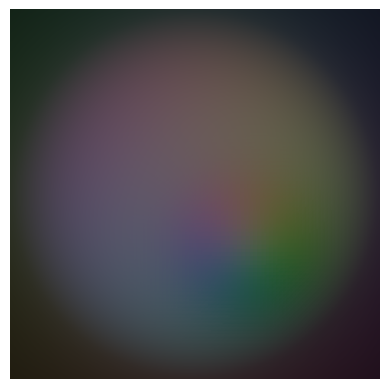

In [6]:
import matplotlib.pyplot as plt

plt.axis('off');
plt.imshow(image)
plt.show()

In [7]:
bmp = mi.Bitmap(image)
bmp = bmp.convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, True)
bmp.write('../scenes/img/normal-10-10.png')